## AE

Epoch [1/5], Loss: 0.0612
Epoch [2/5], Loss: 0.0445
Epoch [3/5], Loss: 0.0399
Epoch [4/5], Loss: 0.0379
Epoch [5/5], Loss: 0.0367


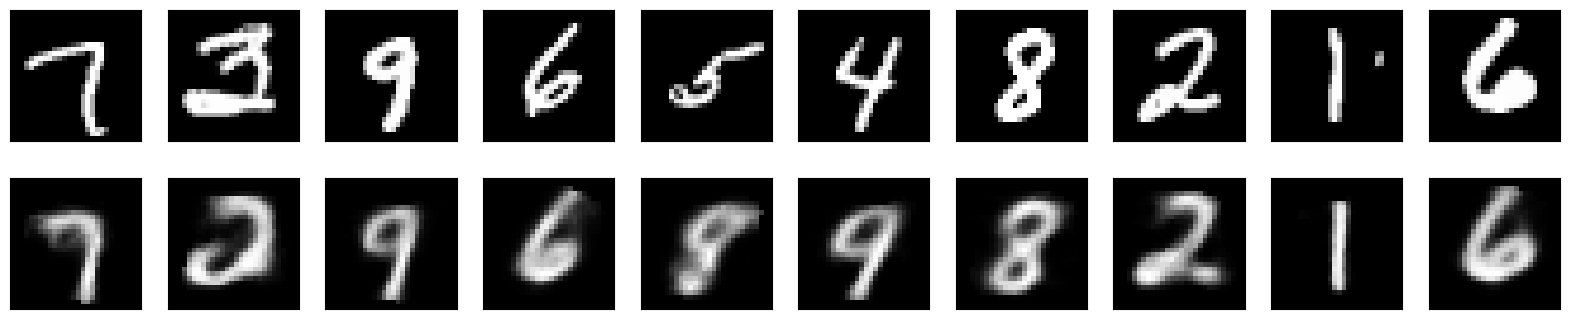

In [40]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Hyperparameters
learning_rate = 0.001
batch_size = 64
num_epochs = 5

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3))

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Display original and reconstructed images
def display_images(in_, out, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(in_[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(out[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Select a batch of images
dataiter = iter(train_loader)
images, _ = next(dataiter)

# Get the output from the model
output = model(images.view(images.size(0), -1))

# Display images
display_images(images, output.detach())


## VAE

https://arxiv.org/abs/1606.05908 \
https://www.youtube.com/watch?v=iL1c1KmYPM0

<img src="src/vae01.png" height=600 />

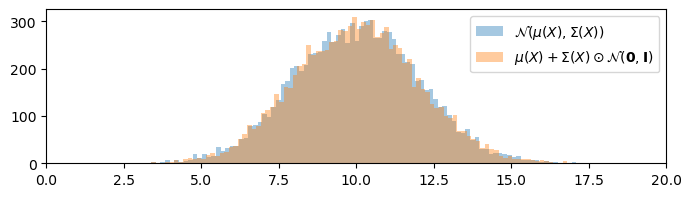

In [41]:
# Reparameterization trick

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

X_mu = 10
X_sigma = 2

plt.figure(figsize=(8,2))

# sampling from the original distribution
plt.hist(norm.rvs(X_mu, X_sigma, 10000), bins=100, alpha=.4, label=r"$\mathcal{N}(\mu(X), \Sigma(X))$")

# sampling from the shifted and scaled normal distribution
# basically identical
plt.hist(X_mu + np.random.randn(10000)*X_sigma, bins=100, alpha=.4, label=r"$\mu(X) + \Sigma(X) \odot \mathcal{N}(\mathbf{0}, \mathbf{I})$")

plt.legend()
plt.xlim(0, 20)
plt.show()

Epoch [1/10], Loss: 9437.0061
Epoch [2/10], Loss: 7407.9397
Epoch [3/10], Loss: 7125.4638
Epoch [4/10], Loss: 6997.3446
Epoch [5/10], Loss: 6918.4862
Epoch [6/10], Loss: 6867.7491
Epoch [7/10], Loss: 6831.1019
Epoch [8/10], Loss: 6798.1230
Epoch [9/10], Loss: 6776.0040
Epoch [10/10], Loss: 6755.6622


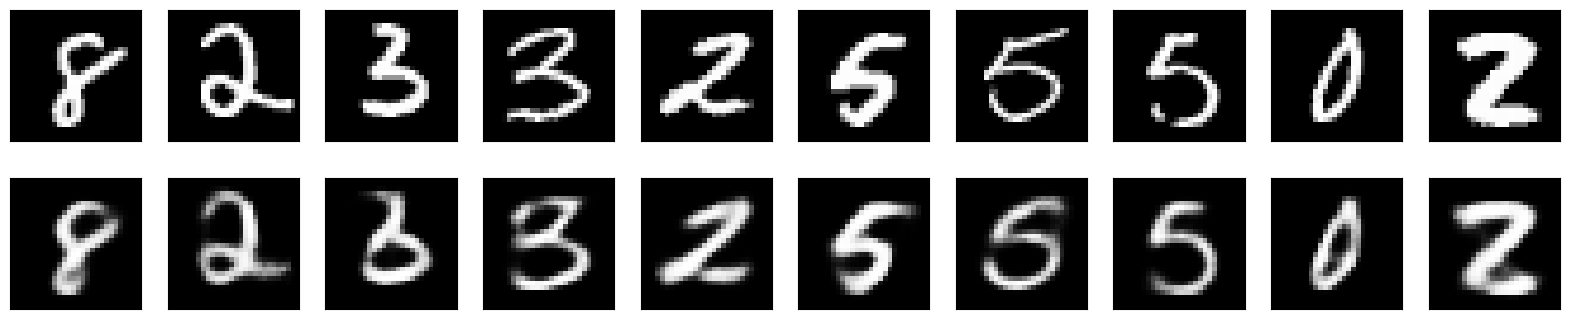

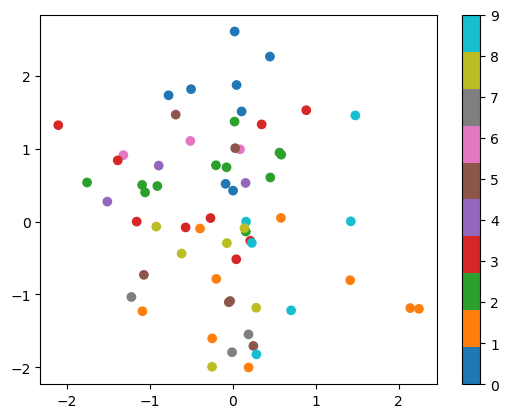

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Hyperparameters
learning_rate = 0.001
batch_size = 64
num_epochs = 10

nn.Conv2d()

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Variational Autoencoder Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, 20) # mean
        self.fc22 = nn.Linear(400, 20) # log variance -> MVN multivariate normal distribution of size 20
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1) # mean, log variance

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar) # std vector of size 20
        eps = torch.randn_like(std) # eps is a standard normal distribution ~N(0,1^2)
        return mu + eps*std # std 

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function for VAE
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

# Training VAE
for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        recon_batch, mu, logvar = vae(img)
        loss = vae_loss(recon_batch, img, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Display original and reconstructed images
def display_images(in_, out, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(in_[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(out[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Visualize latent space
def visualize_latent_space(vae, data_loader):
    vae.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            images = images.view(images.size(0), -1)
            mu, logvar = vae.encode(images)
            z = vae.reparameterize(mu, logvar)
            plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10')
            if i == 0:
                break
    plt.colorbar()
    plt.show()

# Select a batch of images
dataiter = iter(train_loader)
images, _ = next(dataiter)

# Get the output from the model
recon_images, _, _ = vae(images.view(images.size(0), -1))

# Display images
display_images(images, recon_images.detach())

# Visualize latent space
visualize_latent_space(vae, train_loader)
